<a href="https://colab.research.google.com/github/stewieboomhauer/hate-spreadors_detection/blob/main/hate_speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install vaderSentiment
!pip install textstat
!pip install textblob
!pip install demoji

     |████████████████████████████████| 133kB 10.4MB/s 
     |████████████████████████████████| 102kB 6.4MB/s 
     |████████████████████████████████| 1.9MB 19.1MB/s 


In [2]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import pickle
import sys
import re
import os
import xml.etree.ElementTree as et
from collections import Counter
from textstat.textstat import *
from textblob import TextBlob
import demoji
demoji.download_codes()

import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.snowball import SnowballStemmer 
from nltk.util import ngrams

import sklearn as sk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

... OK (Got response in 0.37 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


-------------------------------------------------------
# **1. Loading Data**
-------------------------------------------------------


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
def iter_docs(author):
    author_attr = author.attrib
    for doc in author.iter('document'):
        doc_dict = author_attr.copy()
        doc_dict.update(doc.attrib)
        doc_dict['tweets'] = doc.text
        yield doc_dict

In [5]:
xml ='xml'
df = []
for filename in os.listdir('/content/drive/MyDrive/pan21-author-profiling-training-2021-03-14/en'):
  test_xml = open('/content/drive/MyDrive/pan21-author-profiling-training-2021-03-14/en/{filename}'.format(filename=filename), "r", encoding='utf8')
  etree = et.parse(test_xml) #create an ElementTree object 
  data = pd.DataFrame(list(iter_docs(etree.getroot())))
  data['filename'] = filename
  df.append(data)

In [6]:
def iter_docs(author):
    author_attr = author.attrib
    for doc in author.iter('documents'):
        doc_dict = author_attr.copy()
        doc_dict.update(doc.attrib)
        doc_dict['tweets'] = doc.text
        yield doc_dict

In [7]:
xml ='xml'
df_new = []
for filename in os.listdir('/content/drive/MyDrive/pan21-author-profiling-training-2021-03-14/en'):
  test_xml = open('/content/drive/MyDrive/pan21-author-profiling-training-2021-03-14/en/{filename}'.format(filename=filename), "r", encoding='utf8')
  #mylist = test_xml.readlines()
  etree = et.parse(test_xml) #create an ElementTree object 
  data = pd.DataFrame(list(iter_docs(etree.getroot())))
  data['filename'] = filename
  df_new.append(data)
  #df = pdx.read_xml(mylist, ['author'], ['documents'])

# **2. Preprocessing**

## **2.1 Automatic Sentiment Analyses of Tweets**

In [8]:
analyzer = SentimentIntensityAnalyzer()

dfs = pd.concat(df, ignore_index=True)

dfs['neg'] = dfs['tweets'].apply(lambda x:analyzer.polarity_scores(x)['neg'])
dfs['neu'] = dfs['tweets'].apply(lambda x:analyzer.polarity_scores(x)['neu'])
dfs['pos'] = dfs['tweets'].apply(lambda x:analyzer.polarity_scores(x)['pos'])
dfs['compound'] = dfs['tweets'].apply(lambda x:analyzer.polarity_scores(x)['compound'])
dfs

,lang,class,tweets,filename,neg,neu,pos,compound
0,en,0,RT #USER#: #USER# VECTIV™ technology is here. ...,88d8ac4ae2d91e681ee8a8d3b60fd911.xml,0.000,1.000,0.000,0.0000
1,en,0,In order to expand the possibilities vs the ou...,88d8ac4ae2d91e681ee8a8d3b60fd911.xml,0.000,0.905,0.095,0.3182
2,en,0,#USER# should find me on LinkedIn,88d8ac4ae2d91e681ee8a8d3b60fd911.xml,0.000,1.000,0.000,0.0000
3,en,0,RT #USER#: Happy Founder’s Day #USER# from #US...,88d8ac4ae2d91e681ee8a8d3b60fd911.xml,0.000,0.709,0.291,0.5719
4,en,0,RT #USER#: Loona debuted the electrifying musi...,88d8ac4ae2d91e681ee8a8d3b60fd911.xml,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...
39995,en,1,RT #USER#: This savage needs to be locked in a...,65042b6a94addf20c6fafd782c5d4347.xml,0.412,0.588,0.000,-0.8271
39996,en,1,"RT #USER#: Is it really a ""conspiracy theory"" ...",65042b6a94addf20c6fafd782c5d4347.xml,0.209,0.791,0.000,-0.5709
39997,en,1,#USER# Jews brought them here,65042b6a94addf20c6fafd782c5d4347.xml,0.000,1.000,0.000,0.0000
39998,en,1,RT #USER#: Black men harass and assault White ...,65042b6a94addf20c6fafd782c5d4347.xml,0.333,0.667,0.000,-0.7906


## **2.2 Tokens Distribution**

In [9]:
all_tweets =dfs["tweets"]


In [10]:
count = 0
num_token_inSentence = []
for sent in all_tweets:
  count = count+1
  word_list = len(sent.split())
  num_token_inSentence.append(word_list)

In [11]:
avg_tokens =sum(num_token_inSentence)/count
print(avg_tokens)

12.273925


In [12]:
dfs["tokens"] = dfs["tweets"].map(lambda text: re.sub(r"[^a-zA-Z0-9' ]", ' ', text)).map(lambda text: text.split())

In [13]:
num = dfs.shape[0]

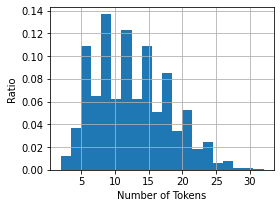

In [14]:
dfs["num_tokens"] = dfs["tokens"].map(len)
ax = dfs["num_tokens"].hist(bins=20, 
                                 figsize=(4,3),
                                 weights=np.ones(num)/num)
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Ratio")
plt.show()

In [15]:
#dfs.to_csv(r'/content/drive/MyDrive/pan21-author-profiling-training-2021-03-14/sentiment_analyses.csv')

## **2.3 Creating Dataframe**

In [16]:
col_one_list = []
for d in df:
  #print(dfs['tweets'])
  col_one_list.append(d['tweets'].tolist())

In [17]:
data = pd.concat(df_new, ignore_index=True)
data.drop(['tweets'], axis=1)

,lang,class,filename
0,en,0,88d8ac4ae2d91e681ee8a8d3b60fd911.xml
1,en,0,86a7f84c2dd126dac46270b6c912952c.xml
2,en,0,9d58d6313bfb2fba9e1e45bb9d65cf0b.xml
3,en,0,f2b1fc84c500c38a93522efbd422b559.xml
4,en,0,26644d1348fc1122e8c5ef45d6bc84fa.xml
...,...,...,...
195,en,1,c129b2cf075e1872a86ce8f7473819af.xml
196,en,1,8b7608a503048538181399629fe67913.xml
197,en,1,5d4a0908d433733c14c38261fc4f4250.xml
198,en,1,a41db55c14ec3878c055eb1ece4e5866.xml


In [18]:
tweets_to_string = []

for elem in col_one_list:
    string = ''.join(elem)
    tweets_to_string.append(string)
    
dataframe = pd.DataFrame(tweets_to_string, columns=["tweets"])

In [19]:
#Create the dataframe, that will be used
data.update(dataframe)

In [20]:
#data = shuffle(data)
data

,lang,class,tweets,filename
0,en,0,RT #USER#: #USER# VECTIV™ technology is here. ...,88d8ac4ae2d91e681ee8a8d3b60fd911.xml
1,en,0,Who wants this accAnd to all the people who su...,86a7f84c2dd126dac46270b6c912952c.xml
2,en,0,#USER# Wait till you get out...it gets worseIt...,9d58d6313bfb2fba9e1e45bb9d65cf0b.xml
3,en,0,If you havent tried Parler yet please give it ...,f2b1fc84c500c38a93522efbd422b559.xml
4,en,0,"#USER# #USER# ""tell people what to do..."" hmm,...",26644d1348fc1122e8c5ef45d6bc84fa.xml
...,...,...,...,...
195,en,1,RT #USER#: The four most dangerous people in t...,c129b2cf075e1872a86ce8f7473819af.xml
196,en,1,Check out my broadcast from my PlayStation 4! ...,8b7608a503048538181399629fe67913.xml
197,en,1,RT #USER#: So Lebron had 30 13 13 goat lmaoWom...,5d4a0908d433733c14c38261fc4f4250.xml
198,en,1,Also not frozen or it will explode. #URL#Same ...,a41db55c14ec3878c055eb1ece4e5866.xml


In [21]:
data.describe()

,lang,class,tweets,filename
count,200,200,200,200
unique,1,2,200,200
top,en,1,"Anti-#HASHTAG# mayor of #HASHTAG#, Ore., has t...",2c38fc584f7566f7010d220c102d6b56.xml
freq,200,100,1,1


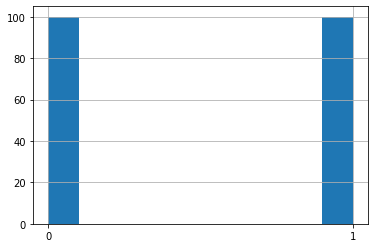

In [22]:

data['class'].hist()

In [23]:
tweets = data["tweets"].copy()

# **3. Methods**

------------------------------------------
## **3.1. Feature Engineering**

**Vectorization**

The following settings for vectorization were used:



*   Word representation: TFIDFVectorizer;
*   N-grams: unigram & bigram & trigram;
*   Convert to lowercase;
*   Try binary counter;
*   Use stop words;

------------------------------------------

### **3.1.1 Creating List with "Stopwords"**

In [24]:

#Tokenize tweets to count words
s = ''.join(tweets_to_string)
#get rid of punctuation
sentence = re.sub(r'[^\w\s]','',s.lower())
tokens = nltk.word_tokenize(sentence)

#Tokens Distribution (word occurrences)
occurrences = Counter(tokens).most_common(63)
dictOftokens = dict(occurrences)

#Tokens with occurrences more than 1000
most_common_tokens = []
for k,v in dictOftokens.items():
  most_common_tokens.append(k)

#Get most common tokens to add them to stopwords
print(most_common_tokens) 

['user', 'the', 'to', 'a', 'i', 'you', 'is', 'and', 'urlrt', 'hashtag', 'of', 'in', 'for', 'this', 'on', 'my', 'it', 'that', 'be', 'urluser', 'me', 'are', 'not', 'with', 'like', 'they', 'just', 'im', 'have', 'your', 'all', 'so', 'dont', 'we', 'its', 'was', 'rt', 'what', 'if', 'do', 'no', 'but', 'get', 'at', 'url', 'up', 'people', 'he', 'by', 'as', 'out', 'will', 'about', 'can', 'from', 'got', 'when', 'how', 'one', 'who', 'know', 'more', 'amp']


In [25]:
#Creating a list with stopwords
stopwords=stopwords = nltk.corpus.stopwords.words("english")
stopwords.extend(most_common_tokens)
stopwords = list(set(stopwords))

### **3.1.2 Preprocess Methods**

In [26]:

#Add preprocess Method
def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

#Add method to get rid of Emojis
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

#Add Word Tokenizer without Stemming
def basic_tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase.
      Returns a list of tokens."""
    list_tokens = []
    for t in tweet:
      sentence = re.sub(r'[^\w\s]','',t.lower())
      list_tokens.append(nltk.word_tokenize(sentence))
    tokens = [item for sublist in list_tokens for item in sublist]
    return tokens

counter = CountVectorizer()
data1 = counter.fit_transform(tweets)
count = pd.DataFrame(data = data1.toarray(), columns = counter.get_feature_names())
unique_words = count.columns[count.sum(axis = 0) == 1]

#Add method to ged rid of unique words
def kick_the_word(s):
    p = re.compile(r"\w+(?:'\w+)*|[^\w\s]")
    b = p.findall(s)
    for word in b:
        if word in unique_words:
            s = s.replace(word, '')
    return s


def analyzer(text):
    text = text.lower()
    tokens = basic_tokenize(text)    
    return [''.join(ngram) for token in tokens for ngram in ngrams(token, 2)]


In [27]:
#Application of methods
tweets = tweets.apply(lambda x: x.replace('#USER#', '').lower())
tweets = tweets.apply(remove_emoji)
tweets = tweets.apply(kick_the_word)
tweets = tweets.str.replace('[^\w\s]','')

## **3.2 N-gram Method**

### **3.2.1 Word N-gram Vectorizer**

In [28]:
tfidf_word = TfidfVectorizer(
    analyzer='word',
    stop_words=stopwords,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75)

In [29]:
#Construct tfidf matrix and get relevant scores
tfidf_words =tfidf_word.fit_transform(tweets).toarray()
vocab_words = {v:i for i, v in enumerate(tfidf_word.get_feature_names())}
idf_vals = tfidf_word.idf_
idf_dict = {i:idf_vals[i] for i in vocab_words.values()} #keys are indices; values are IDF scores


### **3.2.2 Char N-gram Vectorizer**

In [30]:
tfidf_char = TfidfVectorizer(
    analyzer='char',
    stop_words=stopwords,
    preprocessor=preprocess,
    ngram_range=(3, 6),
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75)

In [31]:
#Construct tfidf matrix and get relevant scores
tfidf_chars =tfidf_char.fit_transform(tweets).toarray()
vocab_chars = {v:i for i, v in enumerate(tfidf_char.get_feature_names())}
idf_vals = tfidf_char.idf_
idf_dict = {i:idf_vals[i] for i in vocab_chars.values()} #keys are indices; values are IDF scores


### **3.2.3 POS-TF-IDF Vectorizer**

In [32]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [33]:
#Get POS tags for tweets and save as a string
tweet_tags = []
list_tokens = []
for t in tweets:
    sentence = re.sub(r'[^\w\s]','',t.lower())
    tokens = nltk.word_tokenize(preprocess(sentence))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [34]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

## **3.3 Key phrase-based Method**

In [35]:
def containsAny(str, set):
    """ Check whether sequence str contains ANY of the items in set. """
    return 1 in [c in str for c in set]
    

def proccestxts(col_one_list,txt):
    s=set(())
    for i in open(txt, 'r'):
        s.add(i[:-1])
    vectorizer = CountVectorizer(analyzer='char',ngram_range=(3, 3))
    x = list(s)
    X = vectorizer.fit_transform(x)
    gram=vectorizer.get_feature_names()
    s=set(())
    for i in gram:
        s.add(i)
    #print(s)
    ar=[]
    for i in col_one_list:
        x=0
        for tw in i:
            if TextBlob(tw).polarity<-0.2:
                if containsAny(tw,s):
                    x=x+1
        ar.append(x)
    return ar 



hate_words_list=proccestxts(col_one_list, '/content/drive/MyDrive/pan21-author-profiling-training-2021-03-14/hate_words.txt')
nation_words_list=proccestxts(col_one_list, '/content/drive/MyDrive/pan21-author-profiling-training-2021-03-14/nations.txt')
lgbt_words_list=proccestxts(col_one_list, '/content/drive/MyDrive/pan21-author-profiling-training-2021-03-14/lgbt.txt')
religion_words_list=proccestxts(col_one_list, '/content/drive/MyDrive/pan21-author-profiling-training-2021-03-14/religion.txt')
genders_words_list=proccestxts(col_one_list, '/content/drive/MyDrive/pan21-author-profiling-training-2021-03-14/genders.txt')

myM=[]

myM.append(genders_words_list)
myM.append(lgbt_words_list)
myM.append(religion_words_list)
myM.append(nation_words_list)
myM.append(hate_words_list)


## **3.4 Splitting Datasets for Machine Learning Models**

In [36]:
key_list = np.array(myM)
print(key_list.shape)

ngramm_word = np.concatenate([tfidf_words,pos],axis=1)
print(ngramm_word.shape)
ngramm_char = np.concatenate([tfidf_chars,pos],axis=1)
print(ngramm_char.shape)


(5, 200)
(200, 11346)
(200, 14735)


In [37]:
#Finally get a list of variable names
variables_words = ['']*len(vocab_words)
for k,v in vocab_words.items():
    variables_words[v] = k

variables_chars = ['']*len(vocab_chars)
for k,v in vocab_chars.items():
    variables_chars[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names_words = variables_words+pos_variables
feature_names_chars = variables_chars+pos_variables

In [38]:
X_word = pd.DataFrame(ngramm_word)
X_char = pd.DataFrame(ngramm_char)
X_keyList = pd.DataFrame(key_list.T)

y = data['class'].astype(int)



In [39]:
X_train_word, X_test_word, y_train_word, y_test_word = train_test_split(X_word, y, test_size = 0.3, random_state = 42, shuffle=True)
X_train_word

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,11306,11307,11308,11309,11310,11311,11312,11313,11314,11315,11316,11317,11318,11319,11320,11321,11322,11323,11324,11325,11326,11327,11328,11329,11330,11331,11332,11333,11334,11335,11336,11337,11338,11339,11340,11341,11342,11343,11344,11345
169,0.000000,2.007858,0.0,0.0,0.000000,1.903868,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,3.302585,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,3.525729,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
97,0.000000,4.015716,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,2.328025,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,4.101093,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,4.24786,0.000000,0.0,0.0,3.525729,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,4.352407,2.007858,0.0,0.0,3.900422,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,2.427116,4.688879,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.000000,2.007858,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,3.040221,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,6.815891,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.000000,0.000000,0.0,0.0,0.000000,1.903868,3.253795,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,2.427116,0.000000,4.506558,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.000000,2.007858,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,3.353878,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,0.000000,0.000000,0.0,0.0,0.000000,3.807736,0.000000,4.101093,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,17.32552,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.

In [40]:
X_train_char, X_test_char, y_train_char, y_test_char = train_test_split(X_char, y, test_size = 0.3, random_state = 42, shuffle=True)
X_train_char

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,14695,14696,14697,14698,14699,14700,14701,14702,14703,14704,14705,14706,14707,14708,14709,14710,14711,14712,14713,14714,14715,14716,14717,14718,14719,14720,14721,14722,14723,14724,14725,14726,14727,14728,14729,14730,14731,14732,14733,14734
169,4.793511,2.575364,1.588787,1.903868,0.000000,1.400478,0.000000,6.319274,1.980829,2.035637,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.213939,0.000000,4.482889,0.000000,0.000000,0.000000,1.891598,2.021651,0.000000,0.000000,0.000000,2.021651,4.507580,5.754020,5.53191,0.000000,2.615770,1.941609,2.07881,0.000000,0.000000,1.879477,1.430783,1.84397,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
97,1.597837,2.575364,0.000000,0.000000,2.035637,22.407641,0.000000,0.000000,0.000000,0.000000,6.355149,0.000000,0.000000,5.497228,1.855666,0.000000,4.820908,1.867501,0.000000,0.000000,3.488881,1.941609,0.000000,0.000000,3.288714,3.641961,0.000000,2.021651,1.502527,2.877010,3.68794,0.000000,2.615770,1.941609,2.07881,2.203973,2.491655,0.000000,1.430783,1.84397,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,0.000000,1.287682,0.000000,0.000000,2.035637,0.000000,0.000000,1.579818,1.980829,2.035637,1.588787,0.000000,1.733969,1.832409,1.855666,1.776529,3.213939,0.000000,0.000000,4.099644,0.000000,0.000000,1.891598,0.000000,1.644357,1.820981,0.000000,2.021651,1.502527,0.000000,0.00000,3.250977,0.000000,0.000000,0.00000,0.000000,0.000000,1.879477,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.000000,1.287682,0.000000,0.000000,0.000000,0.000000,4.043302,0.000000,0.000000,0.000000,1.588787,2.007858,1.733969,0.000000,0.000000,1.776529,6.427878,0.000000,1.494296,2.049822,0.000000,1.941609,1.891598,4.043302,3.288714,3.641961,0.000000,0.000000,1.502527,4.315515,5.53191,0.000000,6.539424,1.941609,2.07881,8.815891,7.474965,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,7.989185,2.575364,3.177574,1.903868,8.142550,7.002388,0.000000,0.000000,0.000000,0.000000,9.532723,0.000000,1.733969,3.664818,0.000000,0.000000,4.820908,0.000000,2.988593,0.000000,1.744440,13.591260,3.783196,32.346420,4.933071,1.820981,0.000000,14.151559,1.502527,2.877010,1.84397,3.250977,2.615770,0.000000,0.00000,2.203973,0.000000,1.879477,5.723132,1.84397,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.000000,1.287682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588787,0.000000,1.733969,1.832409,0.000000,0.000000,1.606969,0.000000,0.000000,0.000000,5.233321,1.941609,0.000000,6.064954,0.000000,0.000000,0.000000,2.021651,0.000000,0.000000,0.00000,0.000000,1.307885,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.84397,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.064954,1.579818,1.980829,2.035637,0.000000,0.000000,0.000000,0.000000,0.000000,1.776529,3.213939,0.000000,5.

In [41]:
X_train_keyList, X_test_keyList, y_train_keyList, y_test_keyList = train_test_split(X_keyList, y, test_size = 0.3, random_state = 42, shuffle=True)
X_train_keyList

,0,1,2,3,4
169,8,9,9,15,15
97,22,16,19,32,31
31,7,3,5,11,11
12,15,14,15,26,24
35,46,61,68,77,77
...,...,...,...,...,...
106,17,13,17,27,26
14,9,4,9,15,15
92,8,3,7,22,21
179,10,5,8,16,16


# **4. Machine Learning Models**

# **4.1 Evaluation Metrics for Machine Learning Models**

In [42]:
def evaluate_model_Xy(model, X, y, y_pred=None, label="Training", model_name="model"):
  if y_pred is None:
    y_pred = model.predict(X)

  print(label + ' Set')
  print("Accuracy:", accuracy_score(y, y_pred))
  print()

  print(classification_report(y, y_pred, digits=4))
  disp = plot_confusion_matrix(model, X, y, 
                               cmap=plt.cm.Blues, normalize='true')
  plt.savefig(model_name + "_" + label.lower() + ".png")
  plt.show()
  print()

In [43]:
def evaluate_model_ngrammWord(model, model_name="model",
                   y_train_pred=None, y_dev_pred=None, y_test_pred=None):
  evaluate_model_Xy(model, X_train_word, y_train_word, label="Training", model_name=model_name)
  evaluate_model_Xy(model, X_test_word, y_test_word, label="Testing", model_name=model_name)

In [44]:
def evaluate_model_ngrammChar(model, model_name="model",
                   y_train_pred=None, y_dev_pred=None, y_test_pred=None):
  evaluate_model_Xy(model, X_train_char, y_train_char, label="Training", model_name=model_name)
  evaluate_model_Xy(model, X_test_char, y_test_char, label="Testing", model_name=model_name)

In [45]:
def evaluate_model_keyList(model, model_name="model",
                   y_train_pred=None, y_dev_pred=None, y_test_pred=None):
  evaluate_model_Xy(model, X_train_keyList, y_train_keyList, label="Training", model_name=model_name)
  evaluate_model_Xy(model, X_test_keyList, y_test_keyList, label="Testing", model_name=model_name)

### **4.2 LogisticRegression**

In [46]:
select = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
X_w = select.fit_transform(X_word,y)
X_c = select.fit_transform(X_char,y)
model = LinearSVC(class_weight='balanced',C=0.01, penalty='l2', loss='squared_hinge',multi_class='ovr').fit(X_w, y)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [47]:
final_features_words = select.get_support(indices=True) #get indices of features
final_feature_list = [str(feature_names_words[i]) for i in final_features_words] #Get list of names corresponding to indices

In [48]:
print(final_feature_list)

['510', '52', 'accountable', 'accounts', 'af', 'agendart', 'aid', 'aide', 'aided', 'aint nobody', 'amendment', 'america', 'andy', 'article', 'attach', 'bald', 'ball', 'bay', 'bbc', 'believe', 'birth', 'birth control', 'birthday', 'brort', 'bye', 'candidates', 'censor', 'certainly', 'chair', 'chant', 'chaos', 'clue', 'cole', 'come back', 'committing', 'cos', 'course', 'crazy', 'crazyrt', 'cream', 'criticism', 'dad', 'debt', 'denmark', 'details', 'df', 'dhs', 'discussed', 'discussion', 'dms', 'dort', 'downtown', 'dozen', 'dr', 'enough', 'enough enough', 'enoughrt', 'entirely', 'exciting', 'feelings', 'forward', 'full', 'gets', 'getting ready', 'goddamn', 'godi', 'godrt', 'good night', 'halal', 'halloween', 'hard work', 'heaven', 'hillary', 'horrifying', 'ice cream', 'insanity', 'instead', 'intentions', 'investigated', 'investigating', 'joins', 'july', 'keep good', 'keeping', 'king', 'lady', 'leads', 'leaf', 'leak', 'lies', 'liked', 'likely', 'linked', 'logging', 'material', 'missouri', '

In [49]:
#Getting names for each class of features
ngram_features_words = final_feature_list[:final_feature_list.index('youre saying')+1]
pos_features_words = final_feature_list[final_feature_list.index('youre saying')+1:final_feature_list.index('WP CC')]

In [50]:
new_vocab_words = {v:i for i, v in enumerate(ngram_features_words)}
new_vocab_words_to_index = {}
for k in ngram_features_words:
    new_vocab_words_to_index[k] = vocab_words[k]

In [51]:
#new_vocab_words

In [52]:
model = LinearSVC(class_weight='balanced',C=0.01, penalty='l2', loss='squared_hinge',multi_class='ovr').fit(X_c, y)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [53]:
final_features = select.get_support(indices=True) #get indices of features
final_feature_list = [str(feature_names_chars[i]) for i in final_features] #Get list of names corresponding to indices
print(final_feature_list)

[' amp', ' amp ', ' ass', ' ass ', ' beca', ' best ', ' bit', ' bitc', ' bitch', ' bor', ' cau', ' caus', ' cle', ' done', ' eu', ' fuc', ' fuck', ' gone', ' gone ', ' has b', ' i j', ' i ju', ' i jus', ' jew', ' lis', ' mad ', ' my d', ' mys', ' mysel', ' nigg', ' nigga', ' plan', ' post', ' presi', ' qui', ' sid', ' socia', ' stu', ' stup', ' stupi', ' team', ' to se', ' unde', ' urlu', ' w ', ' wann', ' wanna', ' whit', ' white', ' work ', '00000', '2 pe', '2 peo', '2 peop', 'ag h', 'ag ha', 'ag has', 'ag ur', 'all s', 'ant wa', 'at p', 'auti', 'bam', 'bc ', 'bitc', 'bitch', 'bitch ', 'bout t', 'cent', 'cer', 'checke', 'cks', 'cor', 'cum', 'd k', 'dent ', 'ders', 'dia', 'dly', 'dly ', 'e aut', 'e can ', 'e en', 'e eve', 'e hash', 'e las', 'e peo', 'e peop', 'e pers', 'e url ', 'e way', 'e way ', 'each', 'eav', 'emo', 'eral', 'eric', 'erica', 'erica ', 'es b', 'esi', 'esiden', 'estr', 'fem', 'femi', 'femin', 'fina', 'fuc', 'g has', 'g hash', 'g yo', 'g you ', 'gal', 'gga', 'ggas', 'g

In [54]:
#Getting names for each class of features
ngram_features = final_feature_list[:final_feature_list.index('yself')+1]
pos_features = final_feature_list[final_feature_list.index('yself')+1:final_feature_list.index('JJ VB PRP')]


In [55]:
new_vocab_chars = {v:i for i, v in enumerate(ngram_features)}
new_vocab_chars_to_index = {}
for k in ngram_features:
    new_vocab_chars_to_index[k] = vocab_chars[k]

In [56]:
#new_vocab_chars

In [57]:
clf_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [58]:
param_grid = [{}]

In [59]:
grid_search_lr = GridSearchCV(clf_lr, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_word, y_train_word), 
                           verbose=2)

In [60]:
clf_lr_word = clf_lr.fit(X_train_word, y_train_word)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished


Training Set
Accuracy: 1.0

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        67
           1     1.0000    1.0000    1.0000        73

    accuracy                         1.0000       140
   macro avg     1.0000    1.0000    1.0000       140
weighted avg     1.0000    1.0000    1.0000       140



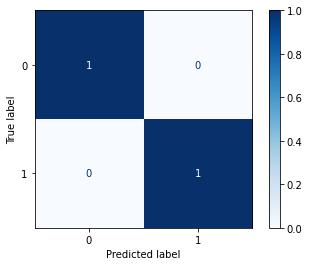


Testing Set
Accuracy: 0.6833333333333333

              precision    recall  f1-score   support

           0     0.7500    0.6364    0.6885        33
           1     0.6250    0.7407    0.6780        27

    accuracy                         0.6833        60
   macro avg     0.6875    0.6886    0.6832        60
weighted avg     0.6937    0.6833    0.6838        60



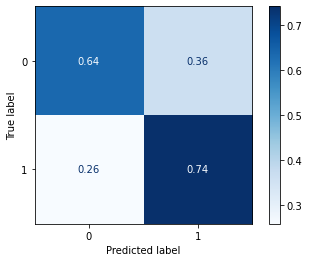

In [61]:
evaluate_model_ngrammWord(clf_lr_word, model_name="clf_lr_word")

In [62]:
grid_search_lr = GridSearchCV(clf_lr, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_char, y_train_char), 
                           verbose=2)

In [63]:
clf_lr_char= clf_lr.fit(X_train_char, y_train_char)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


Training Set
Accuracy: 1.0

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        67
           1     1.0000    1.0000    1.0000        73

    accuracy                         1.0000       140
   macro avg     1.0000    1.0000    1.0000       140
weighted avg     1.0000    1.0000    1.0000       140



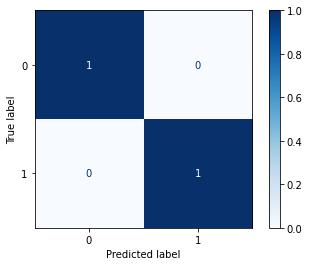


Testing Set
Accuracy: 0.7166666666666667

              precision    recall  f1-score   support

           0     0.7857    0.6667    0.7213        33
           1     0.6562    0.7778    0.7119        27

    accuracy                         0.7167        60
   macro avg     0.7210    0.7222    0.7166        60
weighted avg     0.7275    0.7167    0.7171        60



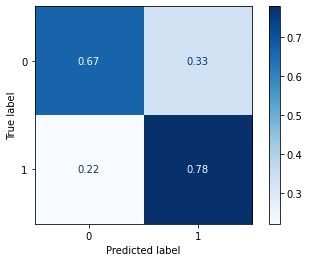

In [64]:
evaluate_model_ngrammChar(clf_lr_char, model_name="clf_lr_char")

In [65]:
grid_search_lr = GridSearchCV(clf_lr, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_keyList, y_train_keyList), 
                           verbose=2)

In [66]:
clf_lr.fit(X_train_keyList, y_train_keyList)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(C=5.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

Training Set
Accuracy: 0.5428571428571428

              precision    recall  f1-score   support

           0     0.5205    0.5672    0.5429        67
           1     0.5672    0.5205    0.5429        73

    accuracy                         0.5429       140
   macro avg     0.5439    0.5439    0.5429       140
weighted avg     0.5449    0.5429    0.5429       140



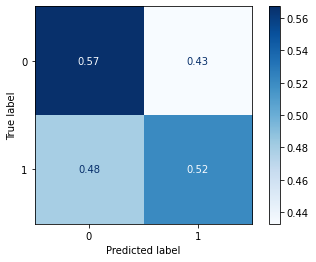


Testing Set
Accuracy: 0.6166666666666667

              precision    recall  f1-score   support

           0     0.6316    0.7273    0.6761        33
           1     0.5909    0.4815    0.5306        27

    accuracy                         0.6167        60
   macro avg     0.6112    0.6044    0.6033        60
weighted avg     0.6133    0.6167    0.6106        60



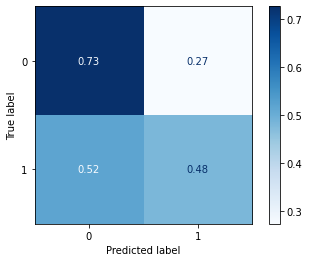

In [67]:
evaluate_model_keyList(clf_lr, model_name="clf_lr_keyList")

In [68]:
del clf_lr

### **4.3 Random Forest**

In [69]:
clf_rf = RandomForestClassifier(n_estimators=500,
                                criterion="gini",
                                max_depth=None, 
                                min_samples_split=2,
                                min_samples_leaf=10, 
                                max_features="auto", 
                                n_jobs=-1,
                                verbose=1,
                                random_state=0,
                                class_weight='balanced')

In [70]:
grid_search_rf = GridSearchCV(clf_rf, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_word, y_train_word), 
                           verbose=2)

In [71]:
clf_rf_word= grid_search_rf.fit(X_train_word, y_train_word)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV] ................................................. , total=   1.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV]  ................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] ................................................. , total=   1.5s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV] ................................................. , total=   1.5s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] ................................................. , total=   1.4s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] ................................................. , total=   1.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


Training Set
Accuracy: 1.0

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        67
           1     1.0000    1.0000    1.0000        73

    accuracy                         1.0000       140
   macro avg     1.0000    1.0000    1.0000       140
weighted avg     1.0000    1.0000    1.0000       140



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


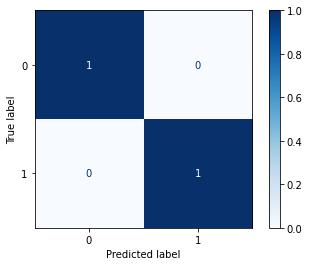

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


Testing Set
Accuracy: 0.65

              precision    recall  f1-score   support

           0     0.6765    0.6970    0.6866        33
           1     0.6154    0.5926    0.6038        27

    accuracy                         0.6500        60
   macro avg     0.6459    0.6448    0.6452        60
weighted avg     0.6490    0.6500    0.6493        60



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


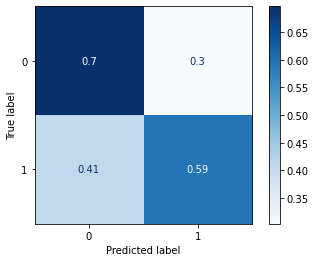

In [72]:
evaluate_model_ngrammWord(clf_rf_word, model_name="clf_rf_word")

In [73]:
X_train_char, X_test_char, y_train_char, y_test_char = train_test_split(X_char, y, test_size = 0.3, random_state = 42, shuffle=True)

In [74]:
grid_search_rf = GridSearchCV(clf_rf, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_char, y_train_char), 
                           verbose=2)

In [75]:
clf_rf_char= grid_search_rf.fit(X_train_char, y_train_char)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] ................................................. , total=   1.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  ................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] ................................................. , total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] ................................................. , total=   1.7s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] ................................................. , total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] ................................................. , total=   1.6s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.1s finished


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


Training Set
Accuracy: 1.0

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        67
           1     1.0000    1.0000    1.0000        73

    accuracy                         1.0000       140
   macro avg     1.0000    1.0000    1.0000       140
weighted avg     1.0000    1.0000    1.0000       140



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


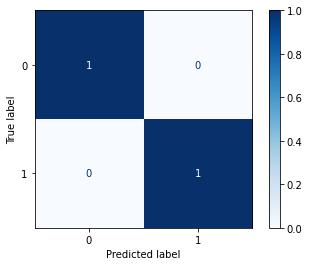

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


Testing Set
Accuracy: 0.7333333333333333

              precision    recall  f1-score   support

           0     0.7179    0.8485    0.7778        33
           1     0.7619    0.5926    0.6667        27

    accuracy                         0.7333        60
   macro avg     0.7399    0.7205    0.7222        60
weighted avg     0.7377    0.7333    0.7278        60



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


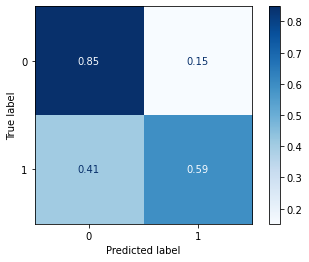

In [76]:
evaluate_model_ngrammChar(clf_rf_char, model_name="clf_rf_char")

In [77]:
grid_search_rf = GridSearchCV(clf_rf, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_keyList, y_train_keyList), 
                           verbose=2)

In [78]:
clf_rf_keyList= grid_search_rf.fit(X_train_keyList, y_train_keyList)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] ................................................. , total=   1.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  ................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] ................................................. , total=   1.3s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] ................................................. , total=   1.3s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] ................................................. , total=   1.3s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] ................................................. , total=   1.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


Training Set
Accuracy: 0.7214285714285714

              precision    recall  f1-score   support

           0     0.6795    0.7910    0.7310        67
           1     0.7742    0.6575    0.7111        73

    accuracy                         0.7214       140
   macro avg     0.7268    0.7243    0.7211       140
weighted avg     0.7289    0.7214    0.7206       140



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


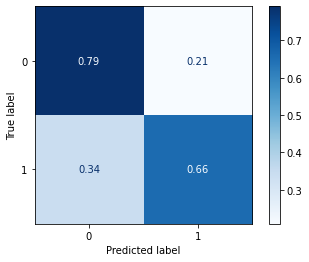

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


Testing Set
Accuracy: 0.7

              precision    recall  f1-score   support

           0     0.7143    0.7576    0.7353        33
           1     0.6800    0.6296    0.6538        27

    accuracy                         0.7000        60
   macro avg     0.6971    0.6936    0.6946        60
weighted avg     0.6989    0.7000    0.6986        60



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


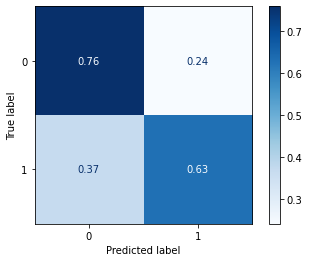

In [79]:
evaluate_model_keyList(clf_rf_keyList, model_name="clf_rf_keyList")

In [80]:
del clf_rf

### **4.4 SGDClassifier**

In [81]:
clf_sgd = make_pipeline(StandardScaler(with_mean=False),
                        SGDClassifier(loss='hinge',
                                      penalty='l2',
                                      alpha=30,
                                      max_iter=1000, 
                                      tol=1e-3,
                                      shuffle=True,
                                      verbose=1,
                                      n_jobs=-1,
                                      random_state=0,
                                      learning_rate='optimal',
                                      early_stopping=True,
                                      class_weight='balanced'))



In [82]:
grid_search_sgd = GridSearchCV(clf_sgd, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_word, y_train_word), 
                           verbose=2)

In [83]:
clf_sgd_word = grid_search_sgd.fit(X_train_word, y_train_word)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
-- Epoch 1
Norm: 0.30, NNZs: 11021, Bias: 0.394678, T: 100, Avg. loss: 1.489562
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 0.19, NNZs: 11259, Bias: 0.393487, T: 200, Avg. loss: 0.248516
Total training time: 0.33 seconds.
-- Epoch 3
Norm: 0.14, NNZs: 11274, Bias: 0.393388, T: 300, Avg. loss: 0.035225
Total training time: 0.36 seconds.
-- Epoch 4
Norm: 0.13, NNZs: 11274, Bias: 0.393171, T: 400, Avg. loss: 0.041554
Total training time: 0.39 seconds.
-- Epoch 5
Norm: 0.13, NNZs: 11273, Bias: 0.393330, T: 500, Avg. loss: 0.064625
Total training time: 0.42 seconds.
-- Epoch 6
Norm: 0.12, NNZs: 11274, Bias: 0.392998, T: 600, Avg. loss: 0.043838
Total training time: 0.45 seconds.
-- Epoch 7
Norm: 0.12, NNZs: 11274, Bias: 0.392802, T: 700, Avg. loss: 0.029259
Total training time: 0.48 seconds.
Convergence after 7 epochs took 0.49 seconds
[CV] ................................................. , total=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  ................................................................
-- Epoch 1
Norm: 0.30, NNZs: 10977, Bias: 0.406276, T: 100, Avg. loss: 1.100123
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 0.18, NNZs: 11255, Bias: 0.406406, T: 200, Avg. loss: 0.285553
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 0.13, NNZs: 11268, Bias: 0.405860, T: 300, Avg. loss: 0.032402
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 0.13, NNZs: 11268, Bias: 0.405806, T: 400, Avg. loss: 0.055674
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 0.13, NNZs: 11268, Bias: 0.405723, T: 500, Avg. loss: 0.068602
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 0.12, NNZs: 11268, Bias: 0.405657, T: 600, Avg. loss: 0.044701
Total training time: 0.10 seconds.
-- Epoch 7
Norm: 0.12, NNZs: 11268, Bias: 0.405411, T: 700, Avg. loss: 0.034748
Total training time: 0.12 seconds.
Convergence after 7 epochs took 0.13 seconds
[CV] ................................................. , total=   0.3s
[CV]  ..

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


-- Epoch 1
Norm: 0.27, NNZs: 11211, Bias: 0.391480, T: 126, Avg. loss: 1.246708
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 0.17, NNZs: 11331, Bias: 0.391790, T: 252, Avg. loss: 0.233613
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 0.14, NNZs: 11332, Bias: 0.391407, T: 378, Avg. loss: 0.053133
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 0.14, NNZs: 11332, Bias: 0.391369, T: 504, Avg. loss: 0.084322
Total training time: 0.13 seconds.
-- Epoch 5
Norm: 0.13, NNZs: 11332, Bias: 0.391058, T: 630, Avg. loss: 0.053260
Total training time: 0.15 seconds.
-- Epoch 6
Norm: 0.12, NNZs: 11332, Bias: 0.391126, T: 756, Avg. loss: 0.046054
Total training time: 0.17 seconds.
Convergence after 6 epochs took 0.18 seconds


Training Set
Accuracy: 0.9428571428571428

              precision    recall  f1-score   support

           0     0.9683    0.9104    0.9385        67
           1     0.9221    0.9726    0.9467        73

    accuracy                         0.9429       140
   macro avg     0.9452    0.9415    0.9426       140
weighted avg     0.9442    0.9429    0.9427       140



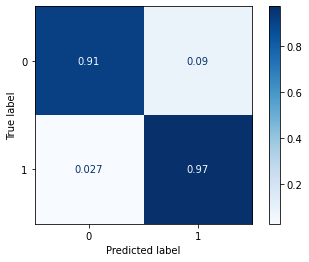


Testing Set
Accuracy: 0.6333333333333333

              precision    recall  f1-score   support

           0     0.7200    0.5455    0.6207        33
           1     0.5714    0.7407    0.6452        27

    accuracy                         0.6333        60
   macro avg     0.6457    0.6431    0.6329        60
weighted avg     0.6531    0.6333    0.6317        60



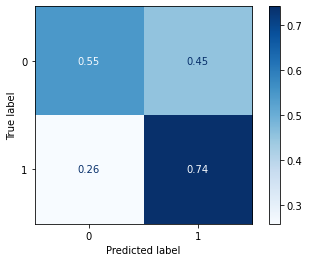

In [84]:
evaluate_model_ngrammWord(clf_sgd_word, model_name="clf_sgd_word")

In [85]:
grid_search_sgd = GridSearchCV(clf_sgd, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_char, y_train_char), 
                           verbose=2)

In [86]:
clf_sgd_char = grid_search_sgd.fit(X_train_char, y_train_char)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
-- Epoch 1
Norm: 0.30, NNZs: 14521, Bias: 0.396480, T: 100, Avg. loss: 3.510345
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 0.20, NNZs: 14690, Bias: 0.395669, T: 200, Avg. loss: 0.499618
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 0.16, NNZs: 14709, Bias: 0.395640, T: 300, Avg. loss: 0.121349
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 0.15, NNZs: 14716, Bias: 0.395649, T: 400, Avg. loss: 0.098359
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 0.13, NNZs: 14716, Bias: 0.395694, T: 500, Avg. loss: 0.029629
Total training time: 0.13 seconds.
-- Epoch 6
Norm: 0.12, NNZs: 14716, Bias: 0.395640, T: 600, Avg. loss: 0.057681
Total training time: 0.16 seconds.
-- Epoch 7
Norm: 0.12, NNZs: 14716, Bias: 0.395490, T: 700, Avg. loss: 0.049243
Total training time: 0.19 seconds.
Convergence after 7 epochs took 0.19 seconds
[CV] ................................................. , total=   0.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  ................................................................
-- Epoch 1
Norm: 0.30, NNZs: 14510, Bias: 0.407404, T: 100, Avg. loss: 2.189178
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 0.20, NNZs: 14677, Bias: 0.407791, T: 200, Avg. loss: 0.386586
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 0.16, NNZs: 14708, Bias: 0.407430, T: 300, Avg. loss: 0.163877
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 0.14, NNZs: 14712, Bias: 0.407473, T: 400, Avg. loss: 0.113523
Total training time: 0.09 seconds.
-- Epoch 5
Norm: 0.13, NNZs: 14712, Bias: 0.407543, T: 500, Avg. loss: 0.073381
Total training time: 0.11 seconds.
-- Epoch 6
Norm: 0.12, NNZs: 14713, Bias: 0.407498, T: 600, Avg. loss: 0.039420
Total training time: 0.12 seconds.
-- Epoch 7
Norm: 0.12, NNZs: 14714, Bias: 0.407405, T: 700, Avg. loss: 0.048815
Total training time: 0.14 seconds.
-- Epoch 8
Norm: 0.11, NNZs: 14714, Bias: 0.407427, T: 800, Avg. loss: 0.017800
Total training time: 0.16 seconds.
Convergen

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished


-- Epoch 1
Norm: 0.27, NNZs: 14673, Bias: 0.393071, T: 126, Avg. loss: 2.807795
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 0.19, NNZs: 14728, Bias: 0.393419, T: 252, Avg. loss: 0.411285
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 0.16, NNZs: 14729, Bias: 0.393365, T: 378, Avg. loss: 0.146996
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 0.14, NNZs: 14729, Bias: 0.393407, T: 504, Avg. loss: 0.086335
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 0.13, NNZs: 14730, Bias: 0.393387, T: 630, Avg. loss: 0.062842
Total training time: 0.14 seconds.
-- Epoch 6
Norm: 0.12, NNZs: 14730, Bias: 0.393405, T: 756, Avg. loss: 0.063759
Total training time: 0.16 seconds.
Convergence after 6 epochs took 0.17 seconds


Training Set
Accuracy: 0.95

              precision    recall  f1-score   support

           0     0.9688    0.9254    0.9466        67
           1     0.9342    0.9726    0.9530        73

    accuracy                         0.9500       140
   macro avg     0.9515    0.9490    0.9498       140
weighted avg     0.9507    0.9500    0.9499       140



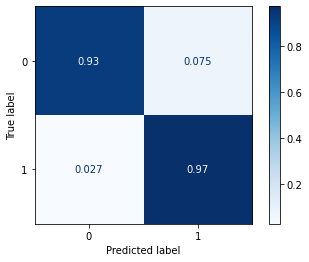


Testing Set
Accuracy: 0.6666666666666666

              precision    recall  f1-score   support

           0     0.8421    0.4848    0.6154        33
           1     0.5854    0.8889    0.7059        27

    accuracy                         0.6667        60
   macro avg     0.7137    0.6869    0.6606        60
weighted avg     0.7266    0.6667    0.6561        60



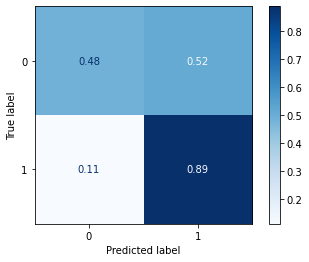

In [87]:
evaluate_model_ngrammChar(clf_sgd_char, model_name="clf_sgd_char")

In [88]:
grid_search_sgd = GridSearchCV(clf_sgd, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_keyList, y_train_keyList), 
                           verbose=2)

In [89]:
clf_sgd_keyList = grid_search_sgd.fit(X_train_keyList, y_train_keyList)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
-- Epoch 1
Norm: 0.02, NNZs: 5, Bias: 0.384593, T: 100, Avg. loss: 0.882770
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.02, NNZs: 5, Bias: 0.385277, T: 200, Avg. loss: 0.867571
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 0.02, NNZs: 5, Bias: 0.385449, T: 300, Avg. loss: 0.868199
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 0.02, NNZs: 5, Bias: 0.385540, T: 400, Avg. loss: 0.868590
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 0.02, NNZs: 5, Bias: 0.385513, T: 500, Avg. loss: 0.868434
Total training time: 0.07 seconds.
-- Epoch 6
Norm: 0.02, NNZs: 5, Bias: 0.385537, T: 600, Avg. loss: 0.868108
Total training time: 0.10 seconds.
Convergence after 6 epochs took 0.11 seconds
[CV] ................................................. , total=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  ................................................................
-- Epoch 1
Norm: 0.01, NNZs: 5, Bias: 0.418529, T: 100, Avg. loss: 0.861732
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.02, NNZs: 5, Bias: 0.419176, T: 200, Avg. loss: 0.867823
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 0.02, NNZs: 5, Bias: 0.419194, T: 300, Avg. loss: 0.866453
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 0.02, NNZs: 5, Bias: 0.419313, T: 400, Avg. loss: 0.863820
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 0.02, NNZs: 5, Bias: 0.419317, T: 500, Avg. loss: 0.864208
Total training time: 0.07 seconds.
-- Epoch 6
Norm: 0.02, NNZs: 5, Bias: 0.419279, T: 600, Avg. loss: 0.864752
Total training time: 0.08 seconds.
Convergence after 6 epochs took 0.08 seconds
[CV] ................................................. , total=   0.1s
[CV]  ................................................................
-- Epoch 1
Norm: 0.01, NNZs: 5, Bias: 0.378549, T: 100, Avg. loss: 0.878925


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


-- Epoch 1
Norm: 0.02, NNZs: 5, Bias: 0.390783, T: 126, Avg. loss: 0.887418
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.02, NNZs: 5, Bias: 0.391011, T: 252, Avg. loss: 0.874227
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 0.02, NNZs: 5, Bias: 0.391085, T: 378, Avg. loss: 0.873866
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 0.02, NNZs: 5, Bias: 0.391088, T: 504, Avg. loss: 0.873223
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 0.02, NNZs: 5, Bias: 0.391140, T: 630, Avg. loss: 0.872630
Total training time: 0.05 seconds.
-- Epoch 6
Norm: 0.02, NNZs: 5, Bias: 0.391168, T: 756, Avg. loss: 0.873208
Total training time: 0.06 seconds.
Convergence after 6 epochs took 0.07 seconds


Training Set
Accuracy: 0.5214285714285715



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        67
           1     0.5214    1.0000    0.6854        73

    accuracy                         0.5214       140
   macro avg     0.2607    0.5000    0.3427       140
weighted avg     0.2719    0.5214    0.3574       140



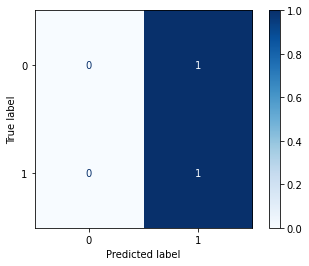


Testing Set
Accuracy: 0.45



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        33
           1     0.4500    1.0000    0.6207        27

    accuracy                         0.4500        60
   macro avg     0.2250    0.5000    0.3103        60
weighted avg     0.2025    0.4500    0.2793        60



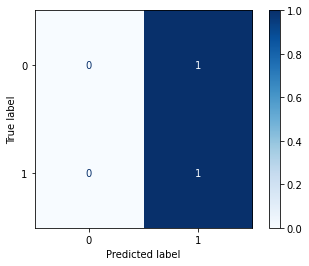

In [90]:
evaluate_model_keyList(clf_sgd_keyList, model_name="clf_sgd_keyList")

In [91]:
del clf_sgd

### **4.5 Neural Network**

In [92]:
clf_nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)

In [93]:
grid_search_nn = GridSearchCV(clf_nn, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_word, y_train_word), 
                           verbose=2)

In [94]:
clf_nn_word = grid_search_nn.fit(X_train_word, y_train_word)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=   1.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  ................................................................
[CV] ................................................. , total=   1.3s
[CV]  ................................................................


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] ................................................. , total=   3.5s
[CV]  ................................................................
[CV] ................................................. , total=   1.2s
[CV]  ................................................................
[CV] ................................................. , total=   1.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.5s finished


Training Set
Accuracy: 0.9928571428571429

              precision    recall  f1-score   support

           0     1.0000    0.9851    0.9925        67
           1     0.9865    1.0000    0.9932        73

    accuracy                         0.9929       140
   macro avg     0.9932    0.9925    0.9928       140
weighted avg     0.9930    0.9929    0.9929       140



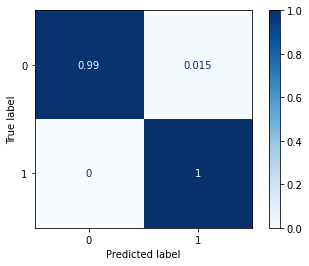


Testing Set
Accuracy: 0.75

              precision    recall  f1-score   support

           0     0.8214    0.6970    0.7541        33
           1     0.6875    0.8148    0.7458        27

    accuracy                         0.7500        60
   macro avg     0.7545    0.7559    0.7499        60
weighted avg     0.7612    0.7500    0.7503        60



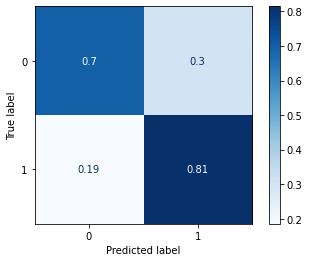

In [95]:
evaluate_model_ngrammWord(clf_nn_word, model_name="clf_nn_word")

In [96]:
grid_search_nn = GridSearchCV(clf_nn, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_char, y_train_char), 
                           verbose=2)

In [97]:

clf_nn_char = grid_search_nn.fit(X_train_char, y_train_char)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=   0.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  ................................................................
[CV] ................................................. , total=   0.4s
[CV]  ................................................................
[CV] ................................................. , total=   0.4s
[CV]  ................................................................
[CV] ................................................. , total=   0.4s
[CV]  ................................................................
[CV] ................................................. , total=   0.4s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.2s finished


Training Set
Accuracy: 0.44285714285714284

              precision    recall  f1-score   support

           0     0.4421    0.6269    0.5185        67
           1     0.4444    0.2740    0.3390        73

    accuracy                         0.4429       140
   macro avg     0.4433    0.4504    0.4288       140
weighted avg     0.4433    0.4429    0.4249       140



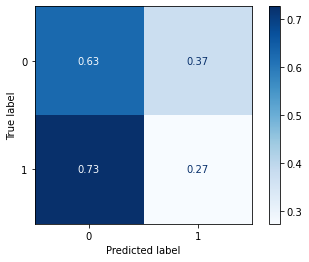


Testing Set
Accuracy: 0.6666666666666666

              precision    recall  f1-score   support

           0     0.6585    0.8182    0.7297        33
           1     0.6842    0.4815    0.5652        27

    accuracy                         0.6667        60
   macro avg     0.6714    0.6498    0.6475        60
weighted avg     0.6701    0.6667    0.6557        60



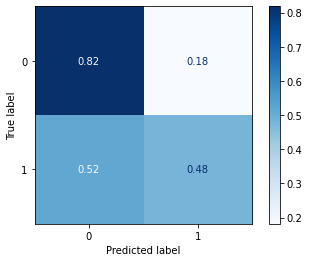

In [98]:
evaluate_model_ngrammChar(clf_nn_char, model_name="clf_nn_char")

In [99]:
grid_search_nn = GridSearchCV(clf_nn, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_keyList, y_train_keyList), 
                           verbose=2)

In [100]:

clf_nn_keyList = grid_search_nn.fit(X_train_keyList, y_train_keyList)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  ................................................................


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] ................................................. , total=   0.1s
[CV]  ................................................................


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] ................................................. , total=   0.1s
[CV]  ................................................................


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] ................................................. , total=   0.1s
[CV]  ................................................................


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV] ................................................. , total=   0.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training Set
Accuracy: 0.5928571428571429

              precision    recall  f1-score   support

           0     0.5781    0.5522    0.5649        67
           1     0.6053    0.6301    0.6174        73

    accuracy                         0.5929       140
   macro avg     0.5917    0.5912    0.5912       140
weighted avg     0.5923    0.5929    0.5923       140



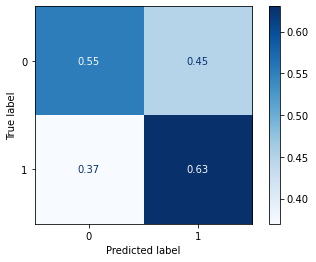


Testing Set
Accuracy: 0.5666666666666667

              precision    recall  f1-score   support

           0     0.6129    0.5758    0.5938        33
           1     0.5172    0.5556    0.5357        27

    accuracy                         0.5667        60
   macro avg     0.5651    0.5657    0.5647        60
weighted avg     0.5699    0.5667    0.5676        60



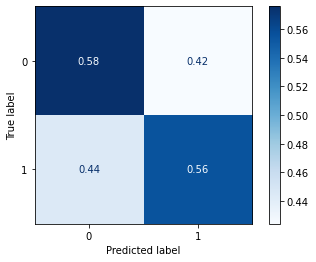

In [101]:
evaluate_model_keyList(clf_nn_keyList, model_name="clf_nn_keyList")

In [102]:
del clf_nn

### **4.6 KNeighborsClassifier**

In [103]:
knn = KNeighborsClassifier(n_neighbors= 18)

In [104]:
grid_search_knn = GridSearchCV(knn, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_word, y_train_word), 
                           verbose=2)

In [105]:

knn_word = grid_search_knn.fit(X_train_word, y_train_word)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  ................................................................
[CV] ................................................. , total=   0.1s
[CV]  ................................................................
[CV] ................................................. , total=   0.1s
[CV]  ................................................................
[CV] ................................................. , total=   0.1s
[CV]  ................................................................
[CV] ................................................. , total=   0.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


Training Set
Accuracy: 0.6214285714285714

              precision    recall  f1-score   support

           0     0.6842    0.3881    0.4952        67
           1     0.5980    0.8356    0.6971        73

    accuracy                         0.6214       140
   macro avg     0.6411    0.6118    0.5962       140
weighted avg     0.6393    0.6214    0.6005       140



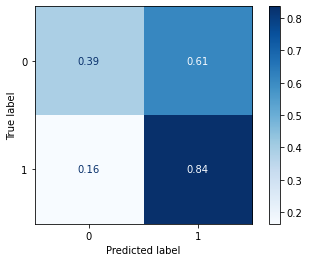


Testing Set
Accuracy: 0.5666666666666667

              precision    recall  f1-score   support

           0     0.7692    0.3030    0.4348        33
           1     0.5106    0.8889    0.6486        27

    accuracy                         0.5667        60
   macro avg     0.6399    0.5960    0.5417        60
weighted avg     0.6529    0.5667    0.5310        60



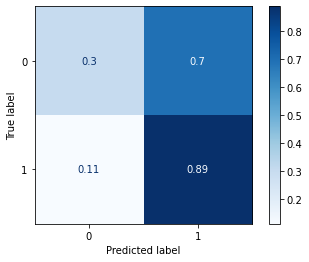

In [106]:
evaluate_model_ngrammWord(knn_word, model_name="knn_word")

In [107]:
grid_search_knn = GridSearchCV(knn, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_char, y_train_char), 
                           verbose=2)

In [108]:

knn_char = grid_search_knn.fit(X_train_char, y_train_char)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  ................................................................
[CV] ................................................. , total=   0.1s
[CV]  ................................................................
[CV] ................................................. , total=   0.1s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] ................................................. , total=   0.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


Training Set
Accuracy: 0.6142857142857143

              precision    recall  f1-score   support

           0     0.6226    0.4925    0.5500        67
           1     0.6092    0.7260    0.6625        73

    accuracy                         0.6143       140
   macro avg     0.6159    0.6093    0.6062       140
weighted avg     0.6156    0.6143    0.6087       140



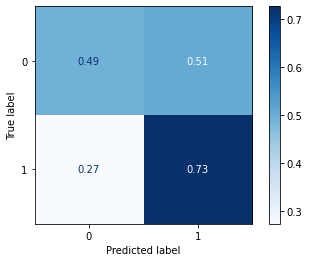


Testing Set
Accuracy: 0.7

              precision    recall  f1-score   support

           0     0.7419    0.6970    0.7188        33
           1     0.6552    0.7037    0.6786        27

    accuracy                         0.7000        60
   macro avg     0.6986    0.7003    0.6987        60
weighted avg     0.7029    0.7000    0.7007        60



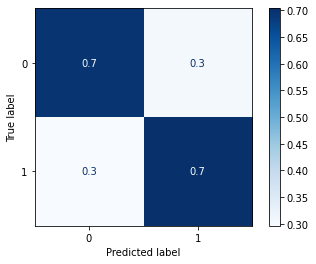

In [109]:
evaluate_model_ngrammChar(knn_char, model_name="knn_char")

In [110]:
grid_search_knn = GridSearchCV(knn, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_keyList, y_train_keyList), 
                           verbose=2)

In [111]:

knn_keyList = grid_search_knn.fit(X_train_keyList, y_train_keyList)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Training Set
Accuracy: 0.6285714285714286

              precision    recall  f1-score   support

           0     0.5843    0.7761    0.6667        67
           1     0.7059    0.4932    0.5806        73

    accuracy                         0.6286       140
   macro avg     0.6451    0.6346    0.6237       140
weighted avg     0.6477    0.6286    0.6218       140



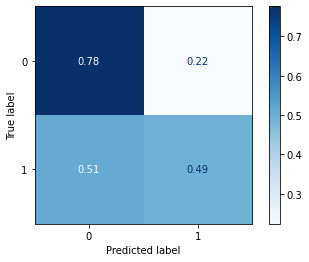


Testing Set
Accuracy: 0.5666666666666667

              precision    recall  f1-score   support

           0     0.6000    0.6364    0.6176        33
           1     0.5200    0.4815    0.5000        27

    accuracy                         0.5667        60
   macro avg     0.5600    0.5589    0.5588        60
weighted avg     0.5640    0.5667    0.5647        60



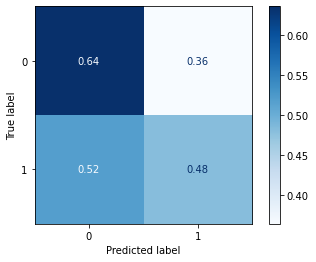

In [112]:
evaluate_model_keyList(knn_keyList, model_name="knn_keyList")

In [113]:
del knn

# **5. Other Features**

In [114]:
def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    words = basic_tokenize(tweet) #Get text only
    syllables = []
    for word in words:
      syllables.append(textstat.syllable_count(word))

    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    #num_terms = len(tweets.split())
    num_words = len(words)
    num_unique_terms = len(set(words))

    avg_syl = []
    for s in syllables:
      avg_syl.append(int(s+0.001)/int(num_words+0.001))
    avg = sum(avg_syl) / len(avg_syl)
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg)),2)

    twitter_objs = []
    retweet = 0
    if "rt" in words:
      retweet = 1
    features = [FKRA, FRE, avg, num_chars, num_chars_total, num_words,
                num_unique_terms,  retweet]
        #features = pandas.DataFrame(features)
    return features


def get_feature_array(tweets):
  feats = []
  for t in tweets:
    feats.append(other_features(t))
  return np.array(feats)


  
other_features_names = ["FKRA", "FRE","avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_words", "num_unique_words", "is_retweet"]

                       

feats = get_feature_array(tweets)

### **5.1 Adding New Features to Data**

In [115]:
M_new = np.concatenate([tfidf_words,pos,feats],axis=1)
M_new.shape

(200, 11354)

In [116]:
X_new = pd.DataFrame(M_new)
y_new = data['class'].astype(int)
X_train_word, X_test_word, y_train_word, y_test_word = train_test_split(X_new, y_new, test_size = 0.3, random_state = 42, shuffle=True)

In [117]:
c_lr = LogisticRegression(penalty='l2',
                            tol=1e-4,
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [118]:
param_grid = [{}]
grid_search_lr = GridSearchCV(c_lr, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_word, y_train_word), 
                           verbose=2)

In [119]:
c_lr.fit(X_train_word, y_train_word)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


LogisticRegression(C=5.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

Training Set
Accuracy: 1.0

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        67
           1     1.0000    1.0000    1.0000        73

    accuracy                         1.0000       140
   macro avg     1.0000    1.0000    1.0000       140
weighted avg     1.0000    1.0000    1.0000       140



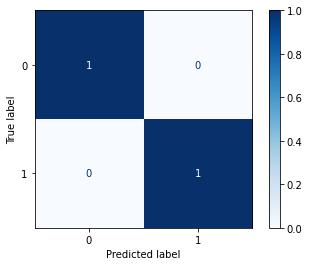


Testing Set
Accuracy: 0.6833333333333333

              precision    recall  f1-score   support

           0     0.7188    0.6970    0.7077        33
           1     0.6429    0.6667    0.6545        27

    accuracy                         0.6833        60
   macro avg     0.6808    0.6818    0.6811        60
weighted avg     0.6846    0.6833    0.6838        60



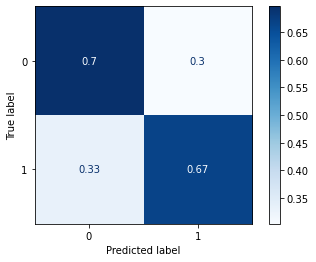

In [120]:
evaluate_model_ngrammWord(c_lr, model_name="lr")

### **5.2 TF-IDF without stopwords**

In [141]:
tfidf_word_no_stopwords = TfidfVectorizer(
    analyzer='word',
    preprocessor=preprocess,
    ngram_range=(1, 3),
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75)

In [142]:
#Construct tfidf matrix and get relevant scores
tfidf =tfidf_word_no_stopwords.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(tfidf_word_no_stopwords.get_feature_names())}
idf_vals = tfidf_word_no_stopwords.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores


In [143]:
array = np.concatenate([tfidf,pos],axis=1)

In [144]:
array.shape

(200, 14735)

In [145]:
X_new = pd.DataFrame(array)
y_new = data['class'].astype(int)
X_train_word, X_test_word, y_train_word, y_test_word = train_test_split(X_new, y_new, test_size = 0.2, random_state = 42, shuffle=True)

In [126]:
clf_nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)

grid_search_nn = GridSearchCV(clf_nn, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_word, y_train_word), 
                           verbose=2)




In [127]:
clf_nn_words = grid_search_nn.fit(X_train_word, y_train_word)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=   2.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  ................................................................
[CV] ................................................. , total=   2.6s
[CV]  ................................................................
[CV] ................................................. , total=   3.2s
[CV]  ................................................................
[CV] ................................................. , total=   1.6s
[CV]  ................................................................
[CV] ................................................. , total=   2.6s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.0s finished


Training Set
Accuracy: 1.0

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        78
           1     1.0000    1.0000    1.0000        82

    accuracy                         1.0000       160
   macro avg     1.0000    1.0000    1.0000       160
weighted avg     1.0000    1.0000    1.0000       160



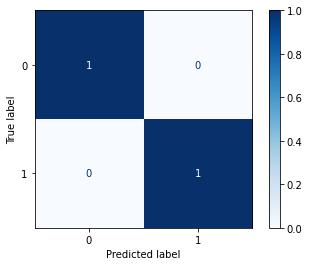


Testing Set
Accuracy: 0.75

              precision    recall  f1-score   support

           0     0.7500    0.8182    0.7826        22
           1     0.7500    0.6667    0.7059        18

    accuracy                         0.7500        40
   macro avg     0.7500    0.7424    0.7442        40
weighted avg     0.7500    0.7500    0.7481        40



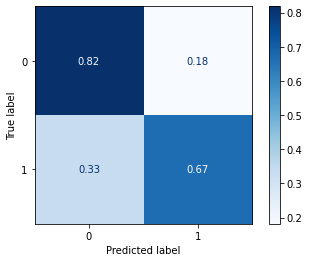

In [128]:
evaluate_model_ngrammWord(clf_nn_words, model_name="clf_nn_words")

In [129]:
clf_rf = RandomForestClassifier(n_estimators=500,
                                criterion="gini",
                                max_depth=None, 
                                min_samples_split=2,
                                min_samples_leaf=10, 
                                max_features="auto", 
                                n_jobs=-1,
                                verbose=1,
                                random_state=0,
                                class_weight='balanced')

In [130]:
grid_search_rf = GridSearchCV(clf_rf, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_word, y_train_word), 
                           verbose=2)

In [131]:
clf_rf_words= grid_search_rf.fit(X_train_word, y_train_word)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] ................................................. , total=   1.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV]  ................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] ................................................. , total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] ................................................. , total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] ................................................. , total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] ................................................. , total=   1.6s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.1s finished


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


Training Set
Accuracy: 0.99375

              precision    recall  f1-score   support

           0     0.9873    1.0000    0.9936        78
           1     1.0000    0.9878    0.9939        82

    accuracy                         0.9938       160
   macro avg     0.9937    0.9939    0.9937       160
weighted avg     0.9938    0.9938    0.9938       160



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


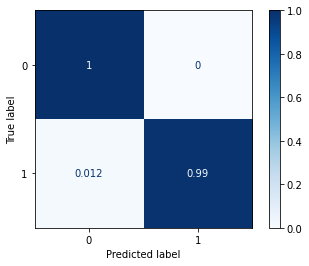

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


Testing Set
Accuracy: 0.65

              precision    recall  f1-score   support

           0     0.6667    0.7273    0.6957        22
           1     0.6250    0.5556    0.5882        18

    accuracy                         0.6500        40
   macro avg     0.6458    0.6414    0.6419        40
weighted avg     0.6479    0.6500    0.6473        40



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


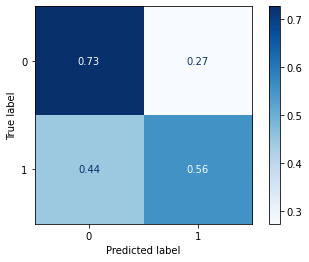

In [132]:
evaluate_model_ngrammWord(clf_rf_words, model_name="clf_rf_words")

In [133]:
clf_sgd = make_pipeline(StandardScaler(with_mean=False),
                        SGDClassifier(loss='hinge',
                                      penalty='l2',
                                      alpha=30,
                                      max_iter=1000, 
                                      tol=1e-3,
                                      shuffle=True,
                                      verbose=1,
                                      n_jobs=-1,
                                      random_state=0,
                                      learning_rate='optimal',
                                      early_stopping=True,
                                      class_weight='balanced'))



In [134]:
grid_search_sgd = GridSearchCV(clf_sgd, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_word, y_train_word), 
                           verbose=2)


In [135]:
clf_sgd = grid_search_sgd.fit(X_train_word, y_train_word)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
-- Epoch 1
Norm: 0.33, NNZs: 14626, Bias: -0.430110, T: 115, Avg. loss: 1.472512
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 0.19, NNZs: 14717, Bias: -0.430494, T: 230, Avg. loss: 0.198127
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 0.14, NNZs: 14725, Bias: -0.430430, T: 345, Avg. loss: 0.022475
Total training time: 0.12 seconds.
-- Epoch 4
Norm: 0.13, NNZs: 14725, Bias: -0.430424, T: 460, Avg. loss: 0.036905
Total training time: 0.16 seconds.
-- Epoch 5
Norm: 0.12, NNZs: 14725, Bias: -0.430486, T: 575, Avg. loss: 0.050098
Total training time: 0.19 seconds.
-- Epoch 6
Norm: 0.12, NNZs: 14725, Bias: -0.430410, T: 690, Avg. loss: 0.043326
Total training time: 0.21 seconds.
-- Epoch 7
Norm: 0.11, NNZs: 14725, Bias: -0.430394, T: 805, Avg. loss: 0.025517
Total training time: 0.23 seconds.
-- Epoch 8
Norm: 0.11, NNZs: 14725, Bias: -0.430341, T: 920, Avg. loss: 0.023323
Total training time: 0.26 seconds.
-

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  ................................................................
-- Epoch 1
Norm: 0.30, NNZs: 14482, Bias: -0.433745, T: 115, Avg. loss: 1.083786
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 0.19, NNZs: 14707, Bias: -0.434625, T: 230, Avg. loss: 0.290140
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 0.14, NNZs: 14713, Bias: -0.433753, T: 345, Avg. loss: 0.048980
Total training time: 0.05 seconds.
-- Epoch 4
Norm: 0.12, NNZs: 14714, Bias: -0.434113, T: 460, Avg. loss: 0.033279
Total training time: 0.08 seconds.
-- Epoch 5
Norm: 0.12, NNZs: 14714, Bias: -0.433861, T: 575, Avg. loss: 0.042928
Total training time: 0.11 seconds.
-- Epoch 6
Norm: 0.12, NNZs: 14714, Bias: -0.433920, T: 690, Avg. loss: 0.043826
Total training time: 0.13 seconds.
Convergence after 6 epochs took 0.14 seconds
[CV] ................................................. , total=   0.3s
[CV]  ................................................................
-- Epoch 1
Norm: 0.30, NNZs: 14551, Bias: -0.4

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished


-- Epoch 1
Norm: 0.30, NNZs: 14719, Bias: 0.399045, T: 144, Avg. loss: 1.441160
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 0.18, NNZs: 14731, Bias: 0.398204, T: 288, Avg. loss: 0.185306
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 0.14, NNZs: 14731, Bias: 0.398240, T: 432, Avg. loss: 0.045801
Total training time: 0.07 seconds.
-- Epoch 4
Norm: 0.13, NNZs: 14731, Bias: 0.397994, T: 576, Avg. loss: 0.069907
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 0.13, NNZs: 14731, Bias: 0.397723, T: 720, Avg. loss: 0.058817
Total training time: 0.14 seconds.
-- Epoch 6
Norm: 0.12, NNZs: 14731, Bias: 0.397649, T: 864, Avg. loss: 0.039111
Total training time: 0.17 seconds.
Convergence after 6 epochs took 0.18 seconds


Training Set
Accuracy: 0.98125

              precision    recall  f1-score   support

           0     0.9870    0.9744    0.9806        78
           1     0.9759    0.9878    0.9818        82

    accuracy                         0.9812       160
   macro avg     0.9815    0.9811    0.9812       160
weighted avg     0.9813    0.9812    0.9812       160



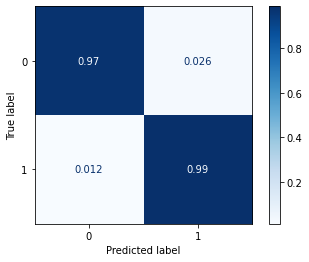


Testing Set
Accuracy: 0.6

              precision    recall  f1-score   support

           0     0.6071    0.7727    0.6800        22
           1     0.5833    0.3889    0.4667        18

    accuracy                         0.6000        40
   macro avg     0.5952    0.5808    0.5733        40
weighted avg     0.5964    0.6000    0.5840        40



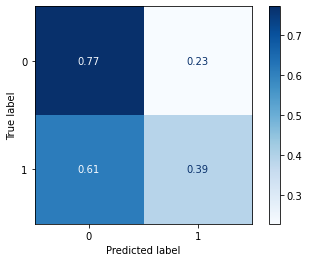

In [136]:
evaluate_model_ngrammWord(clf_sgd, model_name="sgd")

In [137]:
knn = KNeighborsClassifier(n_neighbors= 18)
grid_search_knn = GridSearchCV(knn, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True,
                                              random_state=42).split(X_train_word, y_train_word), 
                           verbose=2)


In [138]:

knn = grid_search_knn.fit(X_train_word, y_train_word)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished


Training Set
Accuracy: 0.58125

              precision    recall  f1-score   support

           0     0.8235    0.1795    0.2947        78
           1     0.5524    0.9634    0.7022        82

    accuracy                         0.5813       160
   macro avg     0.6880    0.5715    0.4985       160
weighted avg     0.6846    0.5813    0.5036       160



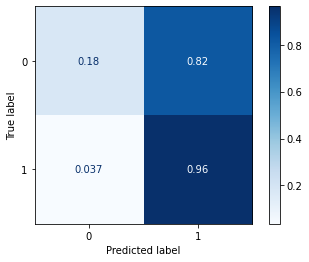


Testing Set
Accuracy: 0.525

              precision    recall  f1-score   support

           0     1.0000    0.1364    0.2400        22
           1     0.4865    1.0000    0.6545        18

    accuracy                         0.5250        40
   macro avg     0.7432    0.5682    0.4473        40
weighted avg     0.7689    0.5250    0.4265        40



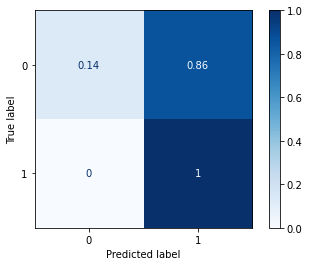

In [139]:
evaluate_model_ngrammWord(knn, model_name="knn")